# Inference demo

This notebook contains all information required to perform inference using an already trained HerdNet model.

Current notebook uses our step-by-step replica of HerdNet, to refer to original implementation and paper checkpoints you can found them  [here](https://github.com/Alexandre-Delplanque/HerdNet/)

## Model weights

We used model weights obtained after perform steps described at [experiment 2](https://github.com/lgemc/animaldet/tree/develop/experiments/HerdNet/experiment_2)

# Assumed folder structure

```
.
├── images
│   ├── image_1.jpg
│   ├── image_2.jpg
│   ├── ...
├── infer.ipynb
```

Output detections will be saved in `detections.csv` file in the current folder.

In [68]:
!gdown --id 1qbWC3K17Ck_GIMrXAsH9cweCHTVBNyMn

/home/lmanrique/Do/animaldet/.venv/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1qbWC3K17Ck_GIMrXAsH9cweCHTVBNyMn
From (redirected): https://drive.google.com/uc?id=1qbWC3K17Ck_GIMrXAsH9cweCHTVBNyMn&confirm=t&uuid=d36db32f-3a17-4142-a617-f292c7b91a91
To: /home/lmanrique/Do/animaldet/experiments/HerdNet/experiment_2/notebooks/best_model_stage_2.pth
100%|████████████████████████████████████████| 220M/220M [00:04<00:00, 46.1MB/s]


In [77]:
MODEL_PATH='./best_model_stage_2.pth'

import hashlib
def md5(fname):
    hash_md5 = hashlib.md5()
    with open(fname, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

assert md5(MODEL_PATH) == '6c67bd01595afcebe4716c6a573132d3', "MD5 checksum does not match!"

In [78]:
import os
from animaloc.utils.seed import set_seed
import albumentations as A
from animaloc.datasets import CSVDataset
import pandas
from animaloc.data.transforms import DownSample
from animaloc.models import HerdNet, LossWrapper, load_model
from torch.utils.data import DataLoader
from animaloc.eval import PointsMetrics, HerdNetStitcher, HerdNetEvaluator
import torch
from PIL import Image

In [79]:
# Settings
IMAGES_PATH="./images"
set_seed(9292)

patch_size = 512
num_classes = 7 # 6 animal classes + 1 background
down_ratio = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


img_names = [i for i in os.listdir(IMAGES_PATH)
        if i.endswith(('.JPG','.jpg','.JPEG','.jpeg'))]
n = len(img_names)

print(f"Found {n} images for inference.")

Found 258 images for inference.


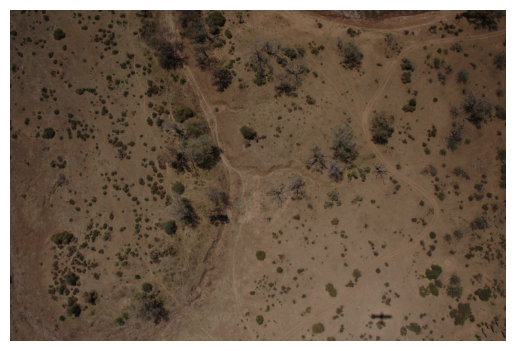

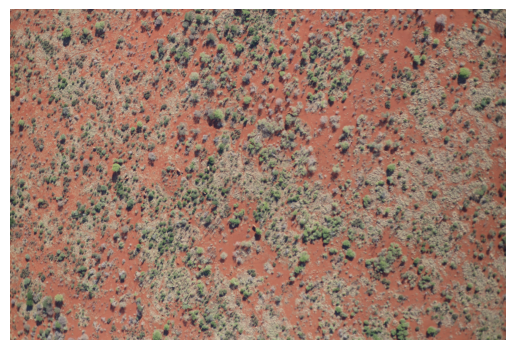

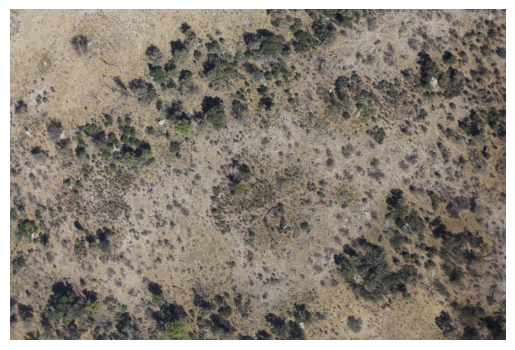

In [80]:
# First 3 images
%matplotlib inline
from matplotlib import pyplot as plt
for i in range(min(3, n)):
    img = plt.imread(os.path.join(IMAGES_PATH, img_names[i]))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [81]:
# Inference dataset and dataloader
df = pandas.DataFrame(data={'images': img_names, 'x': [0]*n, 'y': [0]*n, 'labels': [1]*n})

infer_dataset = CSVDataset(
    csv_file = df,
    root_dir = IMAGES_PATH,
    albu_transforms = [A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    )],
    end_transforms = [DownSample(down_ratio=down_ratio, anno_type='point')]
)

test_dataloader = DataLoader(dataset = infer_dataset, batch_size = 1, shuffle = False)

In [82]:
# Model and stitcher
herdnet = HerdNet(num_classes=num_classes, down_ratio=down_ratio).to(device)
herdnet = LossWrapper(herdnet, losses=[])
herdnet = load_model(herdnet, pth_path=MODEL_PATH)


metrics = PointsMetrics(radius=5, num_classes=num_classes)

stitcher = HerdNetStitcher(
    model=herdnet,
    size=(patch_size,patch_size),
    overlap=0,
    down_ratio=down_ratio,
    reduction='mean',
    up=True
)

In [83]:
# Suppress warnings
import warnings

warnings.filterwarnings(
    "ignore",
    message=r"Got processor for keypoints, but no transform to process it\.",
    category=UserWarning,
    module=r"albumentations\.core\.composition"
)

In [85]:
# Performing inference
evaluator = HerdNetEvaluator(
    model=herdnet,
    dataloader=test_dataloader,
    metrics=metrics,
    stitcher=stitcher,
    work_dir=IMAGES_PATH,
    header='validation',
    print_freq=10,
    lmds_kwargs = dict(kernel_size=(3,3), adapt_ts=0.2, neg_ts=0.1),
)

evaluator.evaluate(log_meters=False) # required to calculate detections
detections = evaluator.detections
# filter detections with null labels
detections = detections[detections['labels'].notnull()]
detections.to_csv("detections.csv", index=False)

validation [  1/258] eta: 0:06:26  time: 1.4987 data: 0.2024 max mem: 3931
validation [ 11/258] eta: 0:06:13  time: 1.5045 data: 0.2126 max mem: 3931
validation [ 21/258] eta: 0:06:00  time: 1.5159 data: 0.2194 max mem: 3931
validation [ 31/258] eta: 0:05:45  time: 1.5241 data: 0.2198 max mem: 3931
validation [ 41/258] eta: 0:05:32  time: 1.5356 data: 0.2223 max mem: 3931
validation [ 51/258] eta: 0:05:18  time: 1.5559 data: 0.2322 max mem: 3931
validation [ 61/258] eta: 0:05:03  time: 1.5476 data: 0.2314 max mem: 3931
validation [ 71/258] eta: 0:04:48  time: 1.5383 data: 0.2309 max mem: 3931
validation [ 81/258] eta: 0:04:33  time: 1.5475 data: 0.2314 max mem: 3931
validation [ 91/258] eta: 0:04:18  time: 1.5459 data: 0.2284 max mem: 3931
validation [101/258] eta: 0:04:03  time: 1.5587 data: 0.2319 max mem: 3931
validation [111/258] eta: 0:03:50  time: 1.6536 data: 0.2561 max mem: 3931
validation [121/258] eta: 0:03:36  time: 1.7221 data: 0.2705 max mem: 3931
validation [131/258] eta:

/home/lmanrique/Do/animaldet/.venv/lib/python3.12/site-packages/animaloc/eval/metrics.py:315: RuntimeWarning: invalid value encountered in divide
  recalls = sorted_table[:,2] / n_gt


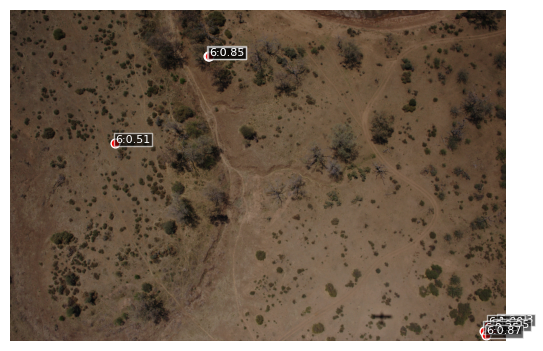

In [86]:
# Detections visualization on first image
img_name = img_names[0]
rows = detections.loc[detections['images'] == img_name]

img = Image.open(os.path.join(IMAGES_PATH, img_name))
plt.imshow(img); plt.axis('off')
plt.scatter(rows['x'], rows['y'], c='r', s=40, edgecolor='white')
for _, r in rows.iterrows():
    plt.text(r['x'] + 6, r['y'] - 6, f"{int(r['labels'])}:{r['scores']:.2f}", color='white',
             fontsize=8, bbox=dict(facecolor='black', alpha=0.6, pad=1))
plt.show()